## Init

In [1]:
multi_iterations=2
# multi_iterations=30 # for GAIW

cube_size=3 # for GAIW
n_levels=2 # for GAIW
cand_size=5 # for GAIW / square side size - means cand_size^2 candidates
n_voters=1000 # for GAIW
# n_voters=500
target = "manual"
rules=['HUV_0', 'sa.HUV_0']
run='synthetic_probas'
cube_proba=[.5, .1, .1, .1, .1, .025, .025, .025, .025]

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") 
sys.path.append("../es/") 

import random
myseed = 13
random.seed(myseed)

import utils
import pandas as pd
import numpy as np
from es.data.synthetic_data_cube import SyntheticDataCubeBuilder
from es.electionutils import ElectionUtils
import es
import es.runner.scenario_runner
from es.runner.view_models import *
import es.elections
import es.utils
import es.Rules

import bokeh
import bokeh.plotting
from bokeh.io import output_notebook
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2
pd.set_option('display.max_rows', 40)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from pandasql import sqldf
sql = lambda q: sqldf(q, globals())
import seaborn as sns
sns.set()

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [3]:
n_candidates = np.power(cube_size**2, n_levels)*cand_size**2

PARAMS =  es.utils.dotdict(dict(
    exp_name='tmp',
    searchterms=['0_0c12'], # for GAIW
    k=10,

    cube_size=cube_size,    
    n_levels=n_levels,
    n_voters=n_voters,
    n_candidates = n_candidates,
    cand_size=cand_size,
    n_approvals_per_voter=int(n_candidates * .08), # for GAIW: 2025*.08 = 162

    cube_proba=cube_proba, # for GAIW
    cand_weight_func=f"lambda x: -np.arctan((x-13)/10)+2", # cand ix proba density - for GAIW
#     cand_weight_func="lambda cand_ix: [0.137, 0.092, 0.078, 0.068, 0.054, 0.043, 0.043, 0.034, 0.033, 0.032, 0.029, 0.028, 0.028, 0.028, 0.026, 0.026, 0.025, 0.025, 0.025, 0.025, 0.025, 0.024, 0.024, 0.024, 0.023][cand_ix]", # netflix implied - max
#     cand_weight_func="lambda cand_ix: [0.087,0.071,0.062,0.057,0.052,0.047,0.045,0.043,0.04,0.038,0.036,0.036,0.035,0.035,0.032,0.031,0.03,0.029,0.029,0.029,0.028,0.028,0.027,0.026,0.026][cand_ix]", # netflix implied - median

#         filtering=dict(sample_orders=1000),
    rules=rules, # prefix sa. means 'use simulated annealing'

    anneal_settings= {'tmax': 9900.0, 'tmin': 0.6, 'steps': 50000, 'updates': 10}, # for GAIW
#     anneal_settings= {'tmax': 9900.0, 'tmin': 0.6, 'steps': 2000, 'updates': 10}, # anneal_settings={'minutes': 0.5},
    scorer_metrics=['tfidfto2'],
    scorer_funcs = [es.scorers.AgentSpreadScoringStrategy.from_found_df_sorted_nosearchterm]
))

out_folder = f"../out/{target}/runner-synthetic/{run}"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)


## Multi Runner
Runs the following multiple `iterations`:
- generate synthetic square data based on `PARAMS` (each time with a different seed)
- returns the results in `multi_results_df`
- shows the square histogram with the total amount of winners per square

In [4]:
%%time
multi_runner = es.runner.view_models.MultiRunner(PARAMS)
multi_results_df = multi_runner.run(iterations=multi_iterations, seed=13, verbose=1, include_unity=False, min_popularity=20)

Running 2 iterations
generating data, iteration 0


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


2022-05-17 12:49:53.550238
searching for: 0.0c12 : ['0_0c12']
----------
RUN: exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)
processing RULE: HUV_0
Using algo/version: g/4
Using optimised HUV_0
greedy score=950.4925789325908 ([101.79333954797491, 100.21564447095076, 97.81949448439862, 96.77377242152004, 95.41104240227673, 94.9949560069624, 94.1750739610319, 93.57838079784841, 90.07700418093411, 85.65387065869297])
processing RULE: sa.HUV_0
Using algo/version: sa/2
first state= [61, 126, 494, 670, 724, 846, 1289, 1703, 1809, 1845]
annealing with: {'tmax': 9900.0, 'tmin': 0.6, 'steps': 50000, 'updates': 10}@ 12:49:53


annealing done @ 12:49:54
annealing score=947.9606948101592
--------------------
RUN: exp_name=tmp;ut_scorer=AgentSpread(tfidfto2), search term: 0.0c12


rank   HUV_0  HUV_0_id sa.HUV_0  sa.HUV_0_id
0     1  0_0c11       100    0_0c1           10
1     2  0_0c13       118    0_0c4           37
2     3   0_0c9        82    0_0c7           64
3     4   0_0c4        37    0_0c9           82
4     5   0_0c1        10   0_0c11          100
5     6   0_0c7        64   0_0c13          118
6     7  0_0c21       190   0_0c17          154
7     8  0_0c19       172   0_0c19          172
8     9  0_0c23       208   0_0c21          190
9    10   0_0c3        28   0_0c23          208

product_id  order_count_found product_name  order_count  tf       idf  \
107         109                 64       0_0c12           64  64  2.748872   
99          100                 20       0_0c11           71  20  2.645075   
116         118                 19       0_0c13           67  19  2.703063   
81           82                 21        0_0c9           82  21  2.501036   
36           37                 22        0_0c4           90  22  2.407946   
9            10                 23        0_0c1           99  23  2.312635   
63           64                 21        0_0c7           86  21  2.453408   
186         190                 13       0_0c21           40  13  3.218876   
169         172                 15       0_0c19           51  15  2.975930   
204         208                 13       0_0c23           43  13  3.146555   

       idfto2       tfidf    tfidfto2      bm25   ratioIn  
107  5.425265  175.927821  347.216943  4.413338  1.000000  
99   5.089667   52.901508  101.793340  2.099592  0.281690  
116  5.274508   51.358191  100.215644  2.065667  0.283582  
81   4.658071   52.521757   97.819494  2.057303  0.256098  
36   4.398808   52.974803   96.773772  2.048304  0.244444  
9    4.148306   53.190615   95.411042  2.030479  0.232323  
63   4.523569   51.521568   94.994956  2.018125  0.244186  
186  7.244236   41.845386   94.175074  1.830286  0.325000  
169  6.238559   44.638945   93.578381  1.897154  0.294118  
204  6.929000   40.905217   90.077004  1.789163  0.302326

Results not saved to file
                                        run_name steps    idf product_id  \
0   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        100   
1   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        118   
2   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         82   
3   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         37   
4   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         10   
5   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         64   
6   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        190   
7   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        172   
8   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        208   
9   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         28   
10  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         10   
11  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1 

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


2022-05-17 12:49:55.990878
searching for: 0.0c12 : ['0_0c12']
----------
RUN: exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)
processing RULE: HUV_0
Using algo/version: g/4
Using optimised HUV_0
greedy score=1037.1924674144757 ([121.04326640414445, 111.97267350277241, 111.90522108488997, 107.94739771107119, 100.92125304646997, 99.72212214698659, 99.23443533863414, 97.86279004307147, 94.5873989570171, 91.99590917941856])
processing RULE: sa.HUV_0
Using algo/version: sa/2
first state= [168, 246, 316, 641, 681, 1111, 1193, 1299, 1631, 1775]
annealing with: {'tmax': 9900.0, 'tmin': 0.6, 'steps': 50000, 'updates': 10}@ 12:49:56


annealing done @ 12:49:57
annealing score=1026.3683607359476
--------------------
RUN: exp_name=tmp;ut_scorer=AgentSpread(tfidfto2), search term: 0.0c12


rank   HUV_0  HUV_0_id sa.HUV_0  sa.HUV_0_id
0     1   0_0c8        73    0_0c1           10
1     2  0_0c13       118    0_0c5           46
2     3  0_0c18       163    0_0c6           55
3     4   0_0c7        64    0_0c7           64
4     5   0_0c6        55    0_0c8           73
5     6  0_0c22       199   0_0c10           91
6     7   0_0c9        82   0_0c13          118
7     8   0_0c1        10   0_0c15          136
8     9   0_0c5        46   0_0c18          163
9    10  0_0c10        91   0_0c22          199

product_id  order_count_found product_name  order_count  tf       idf  \
107         109                 64       0_0c12           64  64  2.748872   
72           73                 21        0_0c8           58  21  2.847312   
116         118                 22       0_0c13           71  22  2.645075   
158         163                 19       0_0c18           56  19  2.882404   
63           64                 23        0_0c7           81  23  2.513306   
54           55                 20        0_0c6           72  20  2.631089   
192         199                 12       0_0c22           32  12  3.442019   
81           82                 20        0_0c9           74  20  2.603690   
9            10                 23        0_0c1           95  23  2.353878   
45           46                 20        0_0c5           80  20  2.525729   

       idfto2       tfidf    tfidfto2      bm25   ratioIn  
107  5.425265  175.927821  347.216943  4.408617  1.000000  
72   5.763965   59.793558  121.043266  2.338233  0.362069  
116  5.089667   58.191659  111.972674  2.246310  0.309859  
158  5.889748   54.765668  111.905221  2.198943  0.339286  
63   4.693365   57.806041  107.947398  2.203077  0.283951  
54   5.046063   52.621783  100.921253  2.084957  0.277778  
192  8.310177   41.304233   99.722122  1.829879  0.375000  
81   4.961722   52.073804   99.234435  2.063246  0.270270  
9    4.254904   54.139203   97.862790  2.063328  0.242105  
45   4.729370   50.514573   94.587399  2.001467  0.250000

Results not saved to file
                                        run_name steps    idf product_id  \
0   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         73   
1   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        118   
2   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        163   
3   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         64   
4   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         55   
5   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        199   
6   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         82   
7   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         10   
8   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         46   
9   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         91   
10  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         10   
11  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1 

In [5]:
from pandasql import sqldf
sql = lambda q: sqldf(q, globals())

df = multi_results_df.copy()
df['cube']=df.product_name.apply(lambda x: x[:3])
df['bigcube']=df.product_name.apply(lambda x: x[:1])
display(df)
df.to_csv(f"{out_folder}/msynth-winners.csv")

sql("select cube, count(*) from df where run_name like '%Agent%' group by cube")

run_name steps    idf product_id  \
0   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        100   
1   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        118   
2   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         82   
3   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         37   
4   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         10   
5   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         64   
6   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        190   
7   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        172   
8   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        208   
9   exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         28   
10  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         10   
11  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         37   
12  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         64   
13  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         82   
14  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        100   
15  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        118   
16  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        154   
17  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        172   
18  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        190   
19  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        208   
20  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         73   
21  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        118   
22  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        163   
23  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         64   
24  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         55   
25  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        199   
26  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         82   
27  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         10   
28  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         46   
29  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         91   
30  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         10   
31  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         46   
32  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         55   
33  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         64   
34  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         73   
35  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1         91   
36  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        118   
37  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        136   
38  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        163   
39  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)     1  IDF_1        199   

   product_name      rule  rulex algo algo_version rank search_term  \
0        0_0c11     HUV_0  HUV_0    g            4    1      0.0c12   
1        0_0c13     HUV_0  HUV_0    g            4    2      0.0c12   
2         0_0c9     HUV_0  HUV_0    g            4    3      0.0c12   
3         0_0c4     HUV_0  HUV_0    g            4    4      0.0c12   
4         0_0c1     HUV_0  HUV_0    g            4    5      0.0c12   
5         0_0c7     HUV_0  HUV_0    g            4    6      0.0c12   
6        0_0c21     HUV_0  HUV_0    g            4    7      0.0c12   
7        0_0c19     HUV_0  HUV_0    g            4    8      0.0c12   
8        0_0c23     HUV_0  HUV_0    g            4    9      0.0c12   
9         0_0c3     HUV_0  HUV_0    g            4   10      0.0c12   
10        0_0c1  sa.HUV_0  HUV_0   sa            2    1      0.0c12   
11        0_0c4  sa.HUV_0  HUV_0   sa            2    2      0.0c12   


cube  count(*)
0  0_0        40

{'exp_name': 'tmp',
 'searchterms': ['0_0c12'],
 'k': 10,
 'cube_size': 3,
 'n_levels': 2,
 'n_voters': 1000,
 'n_candidates': 2025,
 'cand_size': 5,
 'n_approvals_per_voter': 162,
 'cube_proba': [0.5, 0.1, 0.1, 0.1, 0.1, 0.025, 0.025, 0.025, 0.025],
 'cand_weight_func': 'lambda x: -np.arctan((x-13)/10)+2',
 'rules': ['HUV_0', 'sa.HUV_0'],
 'anneal_settings': {'tmax': 9900.0,
  'tmin': 0.6,
  'steps': 50000,
  'updates': 10},
 'scorer_metrics': ['tfidfto2'],
 'scorer_funcs': [<function es.scorers.AgentSpreadScoringStrategy.from_found_df_sorted_nosearchterm(found_df_sorted_nosearchterm, metric='tfidfto2')>]}

rule  count_11  count_1rest  count_rest
0     HUV_0        20            0           0
1  sa.HUV_0        20            0           0

Saving cube_stats to ../out/manual/runner-synthetic/synthetic_probas/cube_stats.csv
(0) exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)
saving results to: ../out/manual/runner-synthetic/synthetic_probas/msynth-HUV_0.png
saving results to: ../out/manual/runner-synthetic/synthetic_probas/msynth-sa.HUV_0.png


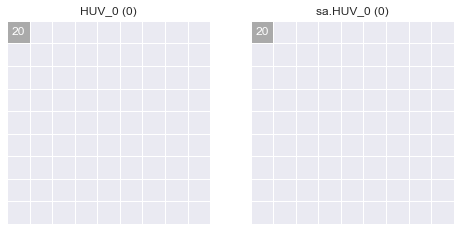

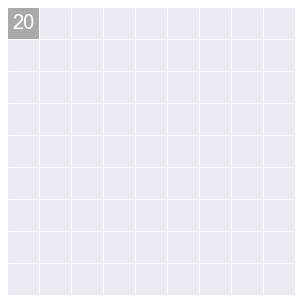

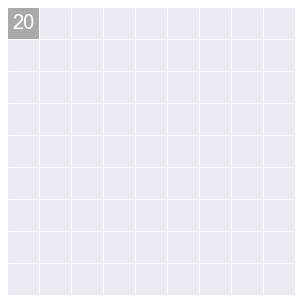

In [6]:
display(PARAMS)
multi_runner.show(multi_results_df, out_folder=out_folder)

## Single Runner

In [7]:
%%time
idata, iframes = SyntheticDataCubeBuilder.from_params(PARAMS, seed=2)

reading instacart data
WARN: Only products with min_popularity=20 considered (0 approvals filtered from 129466 to 129466)
CPU times: user 1.07 s, sys: 38.7 ms, total: 1.1 s
Wall time: 1.03 s


## Show generated elections

voters=1000, candidates=2025, votes=129466


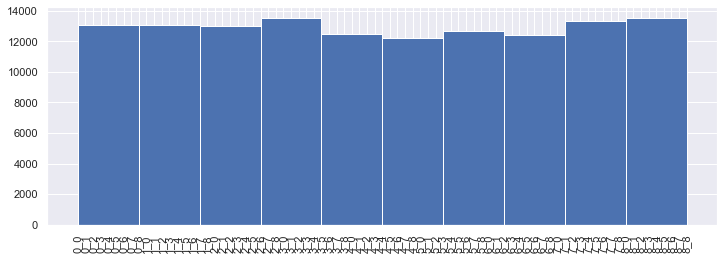

In [8]:
print(f"voters={len(iframes.df_orders)}, candidates={len(iframes.df_products)}, votes={len(iframes.df_order_products)}")
df = iframes.df_order_products.merge(iframes.df_products, on='product_id', how='inner')
df['cell']=df['product_name'].apply(lambda x: x[:3])
df.sort_values(by="cell").cell.hist(figsize=(12,4))
x = plt.xticks(rotation=90)

In [9]:
%%time
exp_folder = es.runner.scenario_runner.ScenarioRunner(iframes, PARAMS).run(verbose=1)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


loaded 2025 products and 1000 orders, (129466 ops)
2022-05-17 12:50:00.934216
dl=1965, avgdl=63.93382716049383, products=1966 metrics_voter_count=1000, real_voter_count=1000
searching for: 0.0c12 : ['0_0c12']
----------
RUN: exp_name=tmp;ut_scorer=None
filtered iframes, products: 1965, orders:  71
processing RULE: HUV_0
Using algo/version: g/4
Using optimised HUV_0
greedy score=224.0 ([28.0, 24.0, 23.0, 23.0, 22.0, 22.0, 22.0, 20.0, 20.0, 20.0])
processing RULE: sa.HUV_0
Using algo/version: sa/2
first state= [14, 159, 348, 435, 544, 743, 836, 877, 1146, 1816]
annealing with: {'tmax': 9900.0, 'tmin': 0.6, 'steps': 50000, 'updates': 10}@ 12:50:01


annealing done @ 12:50:02
annealing score=214.0
--------------------
RUN: exp_name=tmp;ut_scorer=None, search term: 0.0c12


rank   HUV_0  HUV_0_id sa.HUV_0  sa.HUV_0_id
0     1   0_0c2        19    0_0c0            1
1     2   0_0c3        28    0_0c2           19
2     3   0_5c3      1153    0_0c3           28
3     4   0_0c9        82    0_0c4           37
4     5   0_0c8        73    0_0c7           64
5     6   0_0c7        64    0_0c9           82
6     7   0_0c1        10   0_0c10           91
7     8  0_0c20       181   0_0c11          100
8     9   0_0c5        46   0_0c21          190
9    10   0_0c4        37    0_5c3         1153

product_id  order_count_found product_name  order_count  tf       idf  \
108         109                 71       0_0c12           71  71  2.645075   
177         181                 20       0_0c20           49  20  3.015935   
18           19                 28        0_0c2           96  28  2.343407   
81           82                 23        0_0c9           77  23  2.563950   
159         163                 15       0_0c18           40  15  3.218876   
72           73                 22        0_0c8           78  22  2.551046   
186         190                 17       0_0c21           52  17  2.956512   
27           28                 24        0_0c3           95  24  2.353878   
9            10                 22        0_0c1           83  22  2.488915   
63           64                 22        0_0c7           83  22  2.488915   

       idfto2       tfidf    tfidfto2      bm25   ratioIn  
108  5.089667  187.800354  361.366355  4.452960  1.000000  
177  6.393999   60.318700  127.879979  2.396045  0.408163  
18   4.227583   65.615398  118.372318  2.356795  0.291667  
81   4.841890   58.970847  111.363469  2.253008  0.298701  
159  7.244236   48.283137  108.663547  2.053937  0.375000  
72   4.803607   56.123022  105.679359  2.171864  0.282051  
186  6.164478   50.260697  104.796125  2.079098  0.326923  
27   4.254904   56.493081  102.117694  2.131202  0.252632  
9    4.623466   54.756123  101.716244  2.118968  0.265060  
63   4.623466   54.756123  101.716244  2.118968  0.265060

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


----------
RUN: exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)
filtered iframes, products: 1965, orders:  71
processing RULE: HUV_0
Using algo/version: g/4
Using optimised HUV_0
greedy score=1079.856199032839 ([127.87997928655956, 118.37231829802377, 111.36346900666456, 108.66354687811372, 105.67935907881571, 104.79612518931289, 102.11769395798763, 101.71624410297062, 101.71624410297062, 97.55121913141983])
processing RULE: sa.HUV_0
Using algo/version: sa/2
first state= [253, 363, 375, 523, 645, 1063, 1594, 1779, 1861, 1915]
annealing with: {'tmax': 9900.0, 'tmin': 0.6, 'steps': 50000, 'updates': 10}@ 12:50:02


annealing done @ 12:50:03
annealing score=1071.355405830049
--------------------
RUN: exp_name=tmp;ut_scorer=AgentSpread(tfidfto2), search term: 0.0c12


rank   HUV_0  HUV_0_id sa.HUV_0  sa.HUV_0_id
0     1  0_0c20       181    0_0c2           19
1     2   0_0c2        19    0_0c3           28
2     3   0_0c9        82    0_0c7           64
3     4  0_0c18       163    0_0c8           73
4     5   0_0c8        73    0_0c9           82
5     6  0_0c21       190   0_0c13          118
6     7   0_0c3        28   0_0c17          154
7     8   0_0c7        64   0_0c18          163
8     9   0_0c1        10   0_0c20          181
9    10  0_0c13       118   0_0c21          190

product_id  order_count_found product_name  order_count  tf       idf  \
108         109                 71       0_0c12           71  71  2.645075   
177         181                 20       0_0c20           49  20  3.015935   
18           19                 28        0_0c2           96  28  2.343407   
81           82                 23        0_0c9           77  23  2.563950   
159         163                 15       0_0c18           40  15  3.218876   
72           73                 22        0_0c8           78  22  2.551046   
186         190                 17       0_0c21           52  17  2.956512   
27           28                 24        0_0c3           95  24  2.353878   
9            10                 22        0_0c1           83  22  2.488915   
63           64                 22        0_0c7           83  22  2.488915   

       idfto2       tfidf    tfidfto2      bm25   ratioIn  
108  5.089667  187.800354  361.366355  4.452960  1.000000  
177  6.393999   60.318700  127.879979  2.396045  0.408163  
18   4.227583   65.615398  118.372318  2.356795  0.291667  
81   4.841890   58.970847  111.363469  2.253008  0.298701  
159  7.244236   48.283137  108.663547  2.053937  0.375000  
72   4.803607   56.123022  105.679359  2.171864  0.282051  
186  6.164478   50.260697  104.796125  2.079098  0.326923  
27   4.254904   56.493081  102.117694  2.131202  0.252632  
9    4.623466   54.756123  101.716244  2.118968  0.265060  
63   4.623466   54.756123  101.716244  2.118968  0.265060

saved election results to results/tmp/exp=tmp,search=0.0c12,win=10,filtering=None.csv
saved tfidf results to results/tmp/exp=tmp,search=0.0c12,win=10,filtering=None_TFIDF.tsv
Results saved to 'results/tmp'
CPU times: user 2.55 s, sys: 50.8 ms, total: 2.61 s
Wall time: 2.62 s


### Visualisation

In [10]:
es.runner.view_models.show_cube_grid(SyntCubeViewModel(), PARAMS, exp_folder, plot_side=200, max_div_value=1100, 
                                     visual_params=dict(show_tfidf_dots=False, ignore_ranks=True))

{'exp_name': 'tmp', 'searchterms': ['0_0c12'], 'k': 10, 'cube_size': 3, 'n_levels': 2, 'n_voters': 1000, 'n_candidates': 2025, 'cand_size': 5, 'n_approvals_per_voter': 162, 'cube_proba': [0.5, 0.1, 0.1, 0.1, 0.1, 0.025, 0.025, 0.025, 0.025], 'cand_weight_func': 'lambda x: -np.arctan((x-13)/10)+2', 'rules': ['HUV_0', 'sa.HUV_0'], 'anneal_settings': {'tmax': 9900.0, 'tmin': 0.6, 'steps': 50000, 'updates': 10}, 'scorer_metrics': ['tfidfto2'], 'scorer_funcs': [<function AgentSpreadScoringStrategy.from_found_df_sorted_nosearchterm at 0x7f7b717da680>]}
exp=tmp,search=0.0c12,win=10,filtering=None.csv
(0) exp_name=tmp;ut_scorer=None
['HUV_0', 'sa.HUV_0']
                                        run_name  steps    idf  product_id  \
0                    exp_name=tmp;ut_scorer=None      1  IDF_1          19   
1                    exp_name=tmp;ut_scorer=None      1  IDF_1          28   
2                    exp_name=tmp;ut_scorer=None      1  IDF_1        1153   
3                    exp_name=tmp

In [11]:
es.runner.view_models.show_spectrum_grid(SpectrumViewModel(), PARAMS, exp_folder, plot_side=500, plot_height=50, max_div_value=150)

{'exp_name': 'tmp', 'searchterms': ['0_0c12'], 'k': 10, 'cube_size': 3, 'n_levels': 2, 'n_voters': 1000, 'n_candidates': 2025, 'cand_size': 5, 'n_approvals_per_voter': 162, 'cube_proba': [0.5, 0.1, 0.1, 0.1, 0.1, 0.025, 0.025, 0.025, 0.025], 'cand_weight_func': 'lambda x: -np.arctan((x-13)/10)+2', 'rules': ['HUV_0', 'sa.HUV_0'], 'anneal_settings': {'tmax': 9900.0, 'tmin': 0.6, 'steps': 50000, 'updates': 10}, 'scorer_metrics': ['tfidfto2'], 'scorer_funcs': [<function AgentSpreadScoringStrategy.from_found_df_sorted_nosearchterm at 0x7f7b717da680>]}
results/tmp/exp=tmp,search=0.0c12,win=10,filtering=None.csv
(0) exp_name=tmp;ut_scorer=None
(1) exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)


/Users/gregaw/code/ddr/esearch/es/runner/view_models.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x'] = df['product_id'].apply(lambda x: id2coord(x))


diversity metrics:  (ar): average rank


## cube stats

In [12]:
multi_results_df['smallcube']=multi_results_df.product_name.apply(lambda x: x[:3])
multi_results_df['bigcube']=multi_results_df.product_name.apply(lambda x: x[:1])
def cube_stats4rule(rule):
    count_00 = multi_results_df.query(f"smallcube=='0_0' and rule=='{rule}'").product_id.count()
    count_0 = multi_results_df.query(f"bigcube=='0' and rule=='{rule}'").product_id.count()
    count_full = multi_results_df.query(f"rule=='{rule}'").product_id.count()
    return dict(small_square=count_00, large_square=count_0-count_00, all=count_full-count_0)

for rule in sorted(PARAMS.rules):
    print(f"{rule}: {cube_stats4rule(rule)}")



HUV_0: {'small_square': 20, 'large_square': 0, 'all': 0}
sa.HUV_0: {'small_square': 20, 'large_square': 0, 'all': 0}


In [13]:
msynth_stats_df = pd.DataFrame([cube_stats4rule(rule) for rule in sorted(PARAMS.rules)])
msynth_stats_filename = f"{out_folder}/msynth_stats.csv"
msynth_stats_df.to_csv(msynth_stats_filename, index=False)
print(f"Saved synthetic experiment stats to: {msynth_stats_filename}")
msynth_stats_df

Saved synthetic experiment stats to: ../out/manual/runner-synthetic/synthetic_probas/msynth_stats.csv


small_square  large_square  all
0            20             0    0
1            20             0    0